In [1]:
import pandas as pd
from sklearn.datasets import make_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import geopy.distance
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import *

In [2]:
train_file = 'data/out/train_cleaned.csv'
test_file = 'data/out/test_cleaned.csv'

In [3]:
train_data = pd.read_csv(train_file)
train_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
test_data = pd.read_csv(test_file)
test_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [4]:
train_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia,tiempo,distancia_api,tiempo_api,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0,13573.1,1285.1,...,1,0,0,0,0,0,0,0,0,0
1,124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0,14549.1,1210.1,...,1,0,0,0,0,0,0,0,0,0
2,124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0,58253.0,3680.0,...,0,0,0,0,0,0,0,0,0,0
3,124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0,23597.4,1472.8,...,0,0,0,0,0,0,0,0,0,0
4,124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0,14608.3,1154.8,...,1,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia_api,tiempo_api,region_origen_Amazonas,region_origen_Ancash,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124089165,2021-07-20,-12.781050,-74.99228,-12.76703,-74.64612,76381.7,4891.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,124093149,2021-07-31,-7.140513,-78.51395,-7.58284,-78.07524,124606.8,10232.9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,124090750,2021-07-24,-12.010250,-77.11206,-11.99380,-77.02614,20630.3,1631.7,0,0,...,1,0,0,0,0,0,0,0,0,0
3,124092491,2021-07-29,-12.155750,-76.97977,-12.22090,-76.91364,12105.8,1067.6,0,0,...,1,0,0,0,0,0,0,0,0,0
4,124091871,2021-07-27,-12.114920,-77.04678,-12.07910,-77.11724,9403.2,652.5,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
train_data.shape

(1952, 59)

In [7]:
test_data.shape

(852, 57)

In [8]:
X=train_data.loc[:,train_data.columns.isin(['id','fecha','distancia','tiempo']) == False].values
y=train_data.iloc[:,6:8].values
yhat=test_data.iloc[:,2:].values

In [9]:
from sklearn import preprocessing
preprocessing.minmax_scale(X)
preprocessing.minmax_scale(yhat)

array([[0.36037929, 0.52007466, 0.36614227, ..., 0.        , 0.        ,
        0.        ],
       [0.74842017, 0.22806174, 0.72358461, ..., 0.        , 0.        ,
        0.        ],
       [0.4134065 , 0.34430488, 0.41945535, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40340095, 0.3552709 , 0.41559216, ..., 0.        , 0.        ,
        0.        ],
       [0.40340026, 0.3552709 , 0.42098601, ..., 0.        , 0.        ,
        0.        ],
       [0.15010318, 0.93230005, 0.23882396, ..., 0.        , 0.        ,
        0.        ]])

In [10]:
from keras.optimizers import Adam

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mape', optimizer=Adam(learning_rate=0.5e-2))
    return model

In [11]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
print(X.shape[1], y.shape[1])

55 2


In [12]:
from keras.callbacks import ModelCheckpoint

def get_callbacks():
    filepath = 'data/out/try6.h5'
    callback1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callback2 = CSVLogger('data/out/try6.csv')
    
    return [callback1,callback2]

In [13]:
model = get_model(n_inputs, n_outputs)
history = model.fit(X, y, verbose=1, epochs=300, validation_split=0.2, callbacks=get_callbacks())

Epoch 1/300
49/49 [==============================] - 1s 21ms/step - loss: 61.2498 - val_loss: 23.9484

Epoch 00001: loss improved from inf to 49.23563, saving model to data/out\try6.h5
Epoch 2/300
49/49 [==============================] - 0s 2ms/step - loss: 19.4446 - val_loss: 16.4762

Epoch 00002: loss improved from 49.23563 to 17.61103, saving model to data/out\try6.h5
Epoch 3/300
49/49 [==============================] - 0s 2ms/step - loss: 15.3232 - val_loss: 14.7770

Epoch 00003: loss improved from 17.61103 to 14.91614, saving model to data/out\try6.h5
Epoch 4/300
49/49 [==============================] - 0s 1ms/step - loss: 14.4826 - val_loss: 14.4226

Epoch 00004: loss improved from 14.91614 to 14.11713, saving model to data/out\try6.h5
Epoch 5/300
49/49 [==============================] - 0s 2ms/step - loss: 14.6874 - val_loss: 14.0707

Epoch 00005: loss improved from 14.11713 to 14.10188, saving model to data/out\try6.h5
Epoch 6/300
49/49 [==============================] - 0s 1ms

49/49 [==============================] - 0s 1ms/step - loss: 11.7687 - val_loss: 13.2652

Epoch 00052: loss did not improve from 12.01504
Epoch 53/300
49/49 [==============================] - 0s 1ms/step - loss: 11.9474 - val_loss: 13.2055

Epoch 00053: loss did not improve from 12.01504
Epoch 54/300
49/49 [==============================] - 0s 1ms/step - loss: 12.6660 - val_loss: 13.0234

Epoch 00054: loss did not improve from 12.01504
Epoch 55/300
49/49 [==============================] - 0s 1ms/step - loss: 11.9958 - val_loss: 13.5965

Epoch 00055: loss did not improve from 12.01504
Epoch 56/300
49/49 [==============================] - 0s 1ms/step - loss: 12.9032 - val_loss: 13.3460

Epoch 00056: loss did not improve from 12.01504
Epoch 57/300
49/49 [==============================] - 0s 1ms/step - loss: 11.8403 - val_loss: 13.2866

Epoch 00057: loss did not improve from 12.01504
Epoch 58/300
49/49 [==============================] - 0s 1ms/step - loss: 11.9720 - val_loss: 13.2631

Epoc


Epoch 00105: loss did not improve from 11.87402
Epoch 106/300
49/49 [==============================] - 0s 2ms/step - loss: 11.8195 - val_loss: 13.2075

Epoch 00106: loss did not improve from 11.87402
Epoch 107/300
49/49 [==============================] - 0s 2ms/step - loss: 11.6326 - val_loss: 13.0232

Epoch 00107: loss did not improve from 11.87402
Epoch 108/300
49/49 [==============================] - 0s 1ms/step - loss: 11.6521 - val_loss: 12.7465

Epoch 00108: loss improved from 11.87402 to 11.86654, saving model to data/out\try6.h5
Epoch 109/300
49/49 [==============================] - 0s 2ms/step - loss: 11.3970 - val_loss: 12.7117

Epoch 00109: loss did not improve from 11.86654
Epoch 110/300
49/49 [==============================] - 0s 2ms/step - loss: 11.4307 - val_loss: 12.9430

Epoch 00110: loss improved from 11.86654 to 11.83492, saving model to data/out\try6.h5
Epoch 111/300
49/49 [==============================] - 0s 2ms/step - loss: 11.9045 - val_loss: 12.7680

Epoch 001


Epoch 00157: loss did not improve from 11.70784
Epoch 158/300
49/49 [==============================] - 0s 1ms/step - loss: 11.4274 - val_loss: 12.9142

Epoch 00158: loss did not improve from 11.70784
Epoch 159/300
49/49 [==============================] - 0s 1ms/step - loss: 11.8124 - val_loss: 13.0059

Epoch 00159: loss did not improve from 11.70784
Epoch 160/300
49/49 [==============================] - 0s 1ms/step - loss: 12.0170 - val_loss: 12.6895

Epoch 00160: loss did not improve from 11.70784
Epoch 161/300
49/49 [==============================] - 0s 1ms/step - loss: 11.6965 - val_loss: 12.6609

Epoch 00161: loss improved from 11.70784 to 11.65374, saving model to data/out\try6.h5
Epoch 162/300
49/49 [==============================] - 0s 1ms/step - loss: 11.1812 - val_loss: 12.5108

Epoch 00162: loss did not improve from 11.65374
Epoch 163/300
49/49 [==============================] - 0s 1ms/step - loss: 11.4605 - val_loss: 12.6317

Epoch 00163: loss improved from 11.65374 to 11.6

49/49 [==============================] - 0s 1ms/step - loss: 11.3808 - val_loss: 12.3170

Epoch 00210: loss improved from 11.56392 to 11.45570, saving model to data/out\try6.h5
Epoch 211/300
49/49 [==============================] - 0s 1ms/step - loss: 11.1703 - val_loss: 13.3180

Epoch 00211: loss did not improve from 11.45570
Epoch 212/300
49/49 [==============================] - 0s 1ms/step - loss: 12.3579 - val_loss: 12.8454

Epoch 00212: loss did not improve from 11.45570
Epoch 213/300
49/49 [==============================] - 0s 1ms/step - loss: 12.3230 - val_loss: 12.7292

Epoch 00213: loss did not improve from 11.45570
Epoch 214/300
49/49 [==============================] - 0s 1ms/step - loss: 11.8822 - val_loss: 12.5522

Epoch 00214: loss did not improve from 11.45570
Epoch 215/300
49/49 [==============================] - 0s 1ms/step - loss: 11.7357 - val_loss: 12.2776

Epoch 00215: loss did not improve from 11.45570
Epoch 216/300
49/49 [==============================] - 0s 1ms/s

49/49 [==============================] - 0s 1ms/step - loss: 11.1161 - val_loss: 12.1696

Epoch 00263: loss did not improve from 11.39129
Epoch 264/300
49/49 [==============================] - 0s 1ms/step - loss: 11.2399 - val_loss: 12.3643

Epoch 00264: loss did not improve from 11.39129
Epoch 265/300
49/49 [==============================] - 0s 1ms/step - loss: 11.1842 - val_loss: 12.1225

Epoch 00265: loss improved from 11.39129 to 11.35750, saving model to data/out\try6.h5
Epoch 266/300
49/49 [==============================] - 0s 1ms/step - loss: 10.9684 - val_loss: 12.2535

Epoch 00266: loss improved from 11.35750 to 11.28466, saving model to data/out\try6.h5
Epoch 267/300
49/49 [==============================] - 0s 2ms/step - loss: 11.8568 - val_loss: 11.9534

Epoch 00267: loss did not improve from 11.28466
Epoch 268/300
49/49 [==============================] - 0s 1ms/step - loss: 11.5229 - val_loss: 11.9750

Epoch 00268: loss did not improve from 11.28466
Epoch 269/300
49/49 [===

In [14]:
#Cargando el mejor modelo

from keras.models import load_model
best_model_tf = load_model('data/out/try6.h5')

ypred = best_model_tf.predict(yhat)

In [15]:
print(ypred)

[[ 77454.78     5812.2515]
 [126935.484   11075.215 ]
 [ 21311.791    2471.2593]
 ...
 [ 25093.473    2727.2205]
 [ 93248.39     7703.3433]
 [168113.45    10209.149 ]]


In [16]:
best_model_tf.evaluate(X,y)

61/61 [==============================] - 0s 483us/step - loss: 11.2231


11.223060607910156

In [17]:
ids = pd.read_csv(test_file)
ids_1 = ids['id']

In [18]:
df = pd.DataFrame()
df['ID'] = ids_1
df['DISTANCIA'] = ypred[:,0]
df['TIEMPO'] = ypred[:,1]
print(df)

            ID      DISTANCIA        TIEMPO
0    124089165   77454.781250   5812.251465
1    124093149  126935.484375  11075.214844
2    124090750   21311.791016   2471.259277
3    124092491   12554.941406   1668.873169
4    124091871    9595.454102    991.100159
..         ...            ...           ...
847  124088805   15472.452148   2096.615479
848  124089757   12258.010742   1489.513794
849  124089569   25093.472656   2727.220459
850  124092518   93248.390625   7703.343262
851  124090644  168113.453125  10209.149414

[852 rows x 3 columns]


In [19]:
df.to_csv('data/out/try6_out.csv',index=False)

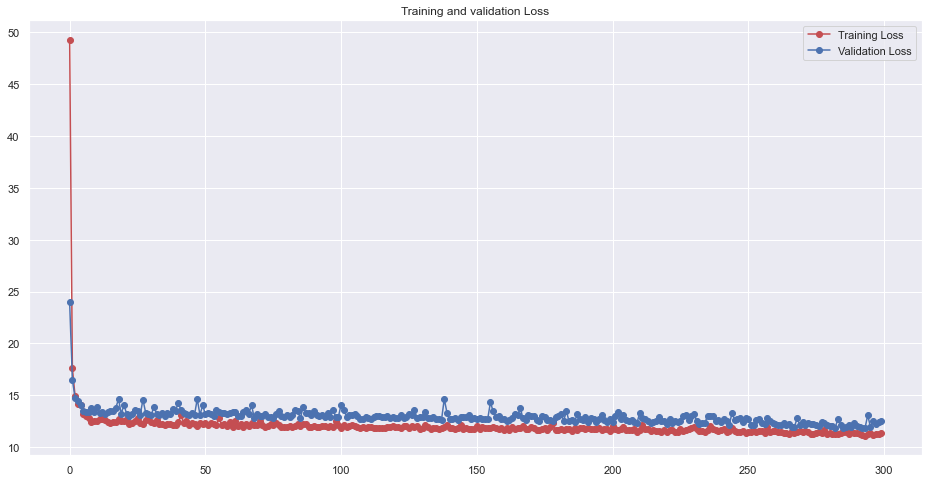

<Figure size 432x288 with 0 Axes>

In [20]:
#Graficar Epochs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,len(loss))
fig = plt.gcf()
fig.set_size_inches(16, 8)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()